# GNN Training

In [15]:
import torch
torch.__version__

'1.12.1'

In [16]:
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
import torch
from torch_geometric.loader import  DataLoader
from torch_geometric.data import Data, InMemoryDataset, download_url
import makePYGdata as mpd
import importlib
importlib.reload(mpd)

<module 'makePYGdata' from '/Users/kylehamilton/MyDocuments/ML-Labs/propaganda-detection/GNN/makePYGdata.py'>

In [53]:
#TODO: filter out non-prop
def removeNonProp(Data):
    return Data.y != 18
    
ptc_data = mpd.PTC_Trees_Dataset(root='data_no_prop',pre_filter=removeNonProp)

Processing...
Found cached dataset parquet (/Users/kylehamilton/.cache/huggingface/datasets/Kyleiwaniec___parquet/Kyleiwaniec--PTC_Corpus-dc238a4991580b39/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/kylehamilton/.cache/huggingface/datasets/Kyleiwaniec___parquet/Kyleiwaniec--PTC_Corpus-dc238a4991580b39/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-aad3be4b871c993a_*_of_00004.arrow
Loading cached processed dataset at /Users/kylehamilton/.cache/huggingface/datasets/Kyleiwaniec___parquet/Kyleiwaniec--PTC_Corpus-dc238a4991580b39/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-910b135e91c33b38_*_of_00004.arrow
Loading cached processed dataset at /Users/kylehamilton/.cache/huggingface/datasets/Kyleiwaniec___parquet/Kyleiwaniec--PTC_Corpus-dc238a4991580b39/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-9d6dfebae211e075_*_of_00004.arrow
processing sentence::   0%|                                                                                                                                | 0/14434 [00:00<?, ?it/s]You're using a T5TokenizerFast tokenizer. Ple

In [17]:
importlib.reload(mpd)
ptc_data = mpd.PTC_Trees_Dataset(root='data_validation')

In [18]:
ptc_data.len()

20584

In [45]:
batch_size = 1

loader = DataLoader(ptc_data, batch_size=batch_size)
pyg_dataset = loader.dataset

train_dataset = pyg_dataset[:14434]
dev_dataset = pyg_dataset[14434:16501] #2067 + 14434 = 16501

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

In [46]:
train_loader.dataset.data['y']

tensor([18,  9,  8,  ...,  7, 18, 18])

In [47]:
train_dataset.num_classes

19

In [48]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, TransformerConv, GraphConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, conv, data):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = conv(data.num_node_features, hidden_channels)
        self.conv2 = conv(hidden_channels, hidden_channels)
        self.conv3 = conv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, data.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64, conv=GATConv, data=train_dataset)
print(model)

GCN(
  (conv1): GATConv(1, 64, heads=1)
  (conv2): GATConv(64, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (lin): Linear(in_features=64, out_features=19, bias=True)
)


In [50]:
len(train_loader)

14434

In [51]:
train_dataset.data

Data(x=[850457, 1], edge_index=[2, 1659746], y=[20584], split=[20584])

In [52]:
import numpy as np
from tqdm import tqdm
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    logits = []
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        logits.append([out,data.y])
    return (correct / loader.dataset.len(), logits) # Derive ratio of correct predictions.

t = tqdm(range(1, 2))
i = 0
for epoch in t:
    train()
    train_acc, train_logits = test(train_loader)
    test_acc, test_logits = test(dev_loader)
    if i%10==0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    i+=1
print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:05<00:00, 125.77s/it]

Epoch: 001, Train Acc: 0.5258, Test Acc: 0.0707
Epoch: 001, Train Acc: 0.5258, Test Acc: 0.0707


In [53]:
names=['Appeal_to_Authority',
     'Appeal_to_fear-prejudice',
     'Bandwagon',
     'Black-and-White_Fallacy',
     'Causal_Oversimplification',
     'Doubt',
     'Exaggeration,Minimisation',
     'Flag-Waving',
     'Loaded_Language',
     'Name_Calling,Labeling',
     'Obfuscation,Intentional_Vagueness,Confusion',
     'Red_Herring',
     'Reductio_ad_hitlerum',
     'Repetition',
     'Slogans',
     'Straw_Men',
     'Thought-terminating_Cliches',
     'Whataboutism',
     'Not_Propaganda']
names = [n.replace("_", " ") for n in names]

In [54]:
Y_hat = defaultdict(int)
for i,l in enumerate(train_logits):
    # print((train_logits[i][0]))
    for t in train_logits[i][0]:
        pred = t.detach().numpy().argmax()
        Y_hat[pred]+=1

In [55]:
print(len(train_logits))
Y_hat

14434


defaultdict(int, {18: 14434})

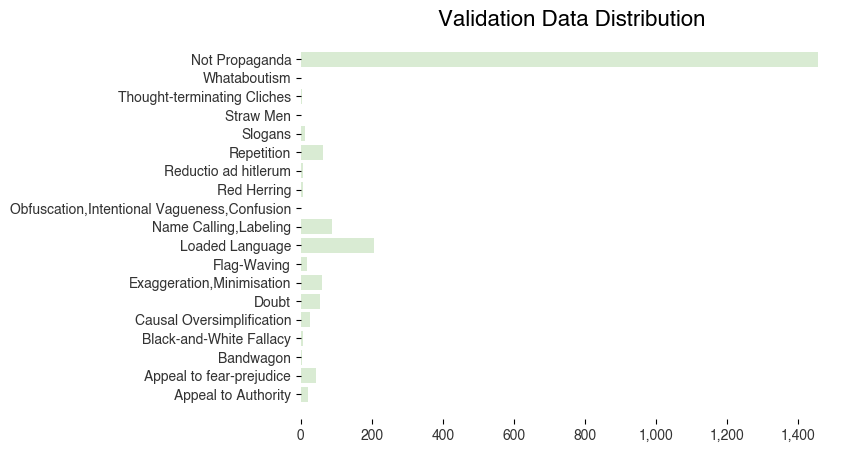

In [101]:
import matplotlib.ticker as mtick
Y = defaultdict(int)
for i,l in enumerate(test_logits):
    y = test_logits[i][1].detach().numpy()[0]
    Y[y]+=1

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.barh(list(Y.keys()),list(Y.values()), color="#d9ebd3")
ymin=min(Y.values())
ymax=max(Y.values())
plt.yticks(np.arange(19),names,rotation=0, color="#333333",font="Helvetica")
plt.xticks(color="#333333",font="Helvetica")
# plt.axis('off')

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)


for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.title("Validation Data Distribution",font="Helvetica",size="16")
plt.show()

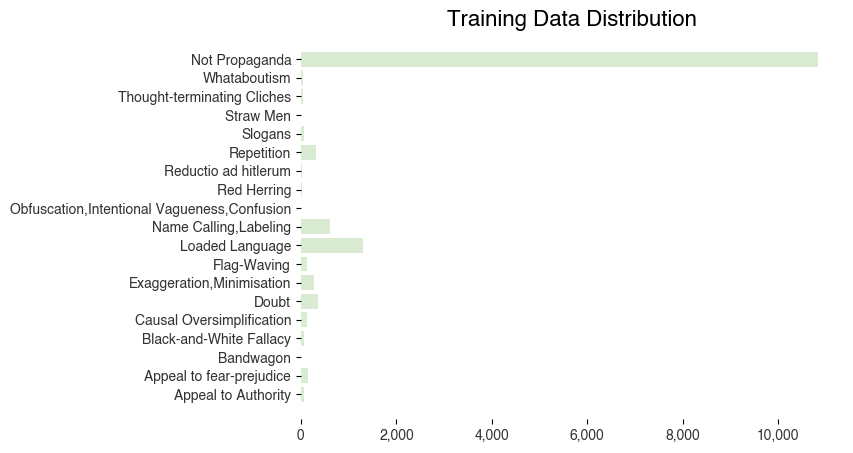

In [102]:
Y = defaultdict(int)
for i,l in enumerate(train_logits):
    y = train_logits[i][1].detach().numpy()[0]
    Y[y]+=1

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.barh(list(Y.keys()),list(Y.values()),color="#d9ebd3")
ymin=min(Y.values())
ymax=max(Y.values())
# plt.axis([0, 18, ymin, ymax])
plt.yticks(np.arange(19),names,rotation=0, color="#333333",font="Helvetica")
plt.xticks(color="#333333",font="Helvetica")

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)


for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.title("Training Data Distribution",font="Helvetica",size="16")
plt.show()

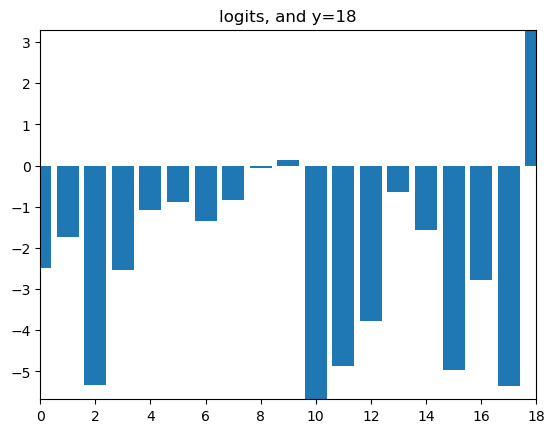

In [76]:
# Single example
i = 0

plt.bar(range(0,19), train_logits[i][0].detach().numpy()[0])
ymin=min(train_logits[i][0].detach().numpy()[0])
ymax=max(train_logits[i][0].detach().numpy()[0])
plt.axis([0, 18, ymin, ymax])
plt.title("logits, and y="+str(train_logits[i][1][0].detach().numpy()))
plt.show()